In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
from sklearn.metrics import accuracy_score,hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
import string

In [2]:
df = pd.read_csv('../data/raw_data.csv')  
print(df.shape)
df.head()

(135556, 131)


,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
1,39773,2790,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,47101,3379,3,4.0,4.0,4.0,4.0,4.0,4.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,43625,7365,3,2.0,3.0,2.0,1.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,12538,488,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,False,False,False,False,False,False,False,False,True,False


In [3]:
cols_to_convert = df.select_dtypes(include=['int', 'float', 'bool']).columns[df.select_dtypes(include=['int', 'float', 'bool']).nunique()<=5]
cols_to_convert

Index(['platform', 'sentiment', 'respect', 'insult', 'humiliate', 'status',
       'dehumanize', 'violence', 'genocide', 'attack_defend',
       ...
       'annotator_religion_hindu', 'annotator_religion_jewish',
       'annotator_religion_mormon', 'annotator_religion_muslim',
       'annotator_religion_nothing', 'annotator_religion_other',
       'annotator_sexuality_bisexual', 'annotator_sexuality_gay',
       'annotator_sexuality_straight', 'annotator_sexuality_other'],
      dtype='object', length=114)

In [4]:
df[cols_to_convert] = df[cols_to_convert].astype(int)
df.head()

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0
1,39773,2790,2,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0
2,47101,3379,3,4,4,4,4,4,4,0,...,0,0,0,0,1,0,0,0,1,0
3,43625,7365,3,2,3,2,1,2,0,0,...,0,0,0,0,0,0,0,0,1,0
4,12538,488,0,4,4,4,4,4,4,4,...,0,0,0,0,0,0,0,0,1,0


In [5]:
target_cols = [col for col in df.columns if 'target' in col]
target_cols

['target_race_asian',
 'target_race_black',
 'target_race_latinx',
 'target_race_middle_eastern',
 'target_race_native_american',
 'target_race_pacific_islander',
 'target_race_white',
 'target_race_other',
 'target_race',
 'target_religion_atheist',
 'target_religion_buddhist',
 'target_religion_christian',
 'target_religion_hindu',
 'target_religion_jewish',
 'target_religion_mormon',
 'target_religion_muslim',
 'target_religion_other',
 'target_religion',
 'target_origin_immigrant',
 'target_origin_migrant_worker',
 'target_origin_specific_country',
 'target_origin_undocumented',
 'target_origin_other',
 'target_origin',
 'target_gender_men',
 'target_gender_non_binary',
 'target_gender_transgender_men',
 'target_gender_transgender_unspecified',
 'target_gender_transgender_women',
 'target_gender_women',
 'target_gender_other',
 'target_gender',
 'target_sexuality_bisexual',
 'target_sexuality_gay',
 'target_sexuality_lesbian',
 'target_sexuality_straight',
 'target_sexuality_other'

In [6]:
annotator_cols = [col for col in df.columns if 'annotator' in col]
annotator_cols

['annotator_id',
 'annotator_severity',
 'annotator_infitms',
 'annotator_outfitms',
 'annotator_gender',
 'annotator_trans',
 'annotator_educ',
 'annotator_income',
 'annotator_ideology',
 'annotator_gender_men',
 'annotator_gender_women',
 'annotator_gender_non_binary',
 'annotator_gender_prefer_not_to_say',
 'annotator_gender_self_describe',
 'annotator_transgender',
 'annotator_cisgender',
 'annotator_transgender_prefer_not_to_say',
 'annotator_education_some_high_school',
 'annotator_education_high_school_grad',
 'annotator_education_some_college',
 'annotator_education_college_grad_aa',
 'annotator_education_college_grad_ba',
 'annotator_education_professional_degree',
 'annotator_education_masters',
 'annotator_education_phd',
 'annotator_income_<10k',
 'annotator_income_10k-50k',
 'annotator_income_50k-100k',
 'annotator_income_100k-200k',
 'annotator_income_>200k',
 'annotator_ideology_extremeley_conservative',
 'annotator_ideology_conservative',
 'annotator_ideology_slightly_

In [7]:
other_cols = list(set(df.columns) - set(annotator_cols) - set(target_cols))
other_cols

['std_err',
 'attack_defend',
 'genocide',
 'infitms',
 'respect',
 'platform',
 'status',
 'sentiment',
 'text',
 'comment_id',
 'insult',
 'violence',
 'dehumanize',
 'hypothesis',
 'humiliate',
 'hatespeech',
 'outfitms',
 'hate_speech_score']

In [8]:
df[other_cols]

,std_err,attack_defend,genocide,infitms,respect,platform,status,sentiment,text,comment_id,insult,violence,dehumanize,hypothesis,humiliate,hatespeech,outfitms,hate_speech_score
0,0.34,0,0,0.81,0,3,2,0,Yes indeed. She sort of reminds me of the elde...,47777,0,0,0,-1.130178,0,0,1.88,-3.90
1,1.00,2,0,0.96,0,2,2,0,The trans women reading this tweet right now i...,39773,0,0,0,-1.146973,0,0,0.43,-6.52
2,0.31,4,0,0.90,4,3,4,4,Question: These 4 broads who criticize America...,47101,4,0,4,-0.207369,4,2,0.74,0.36
3,0.29,3,0,0.81,3,3,2,2,It is about time for all illegals to go back t...,43625,2,0,0,-0.055536,1,0,0.68,0.26
4,0.51,3,1,0.76,4,0,4,4,For starters bend over the one in pink and kic...,12538,4,4,4,0.104225,4,2,0.63,1.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135551,0.69,2,0,0.16,1,2,2,1,عاجل سماحة #السيد_عبدالملك_بدرالدين_الحوثي نص...,37080,0,0,0,-0.036250,0,0,0.11,-4.88
135552,0.35,1,0,1.30,0,2,2,2,Millions of #Yemen-is participated in mass ral...,22986,0,0,0,-0.974684,0,0,0.43,-4.40
135553,0.37,1,0,1.11,1,2,1,1,@AbeShinzo @realDonaldTrump @shinzoabe 独裁者は行きま...,21008,1,0,0,-0.491960,1,0,1.29,-2.49
135554,0.35,2,0,1.30,0,2,2,2,Millions of #Yemen-is participated in mass ral...,22986,0,0,0,-0.974684,0,0,0.43,-4.40


In [9]:
df[target_cols].head()

,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_race_other,target_race,target_religion_atheist,...,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability
0,1,1,1,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


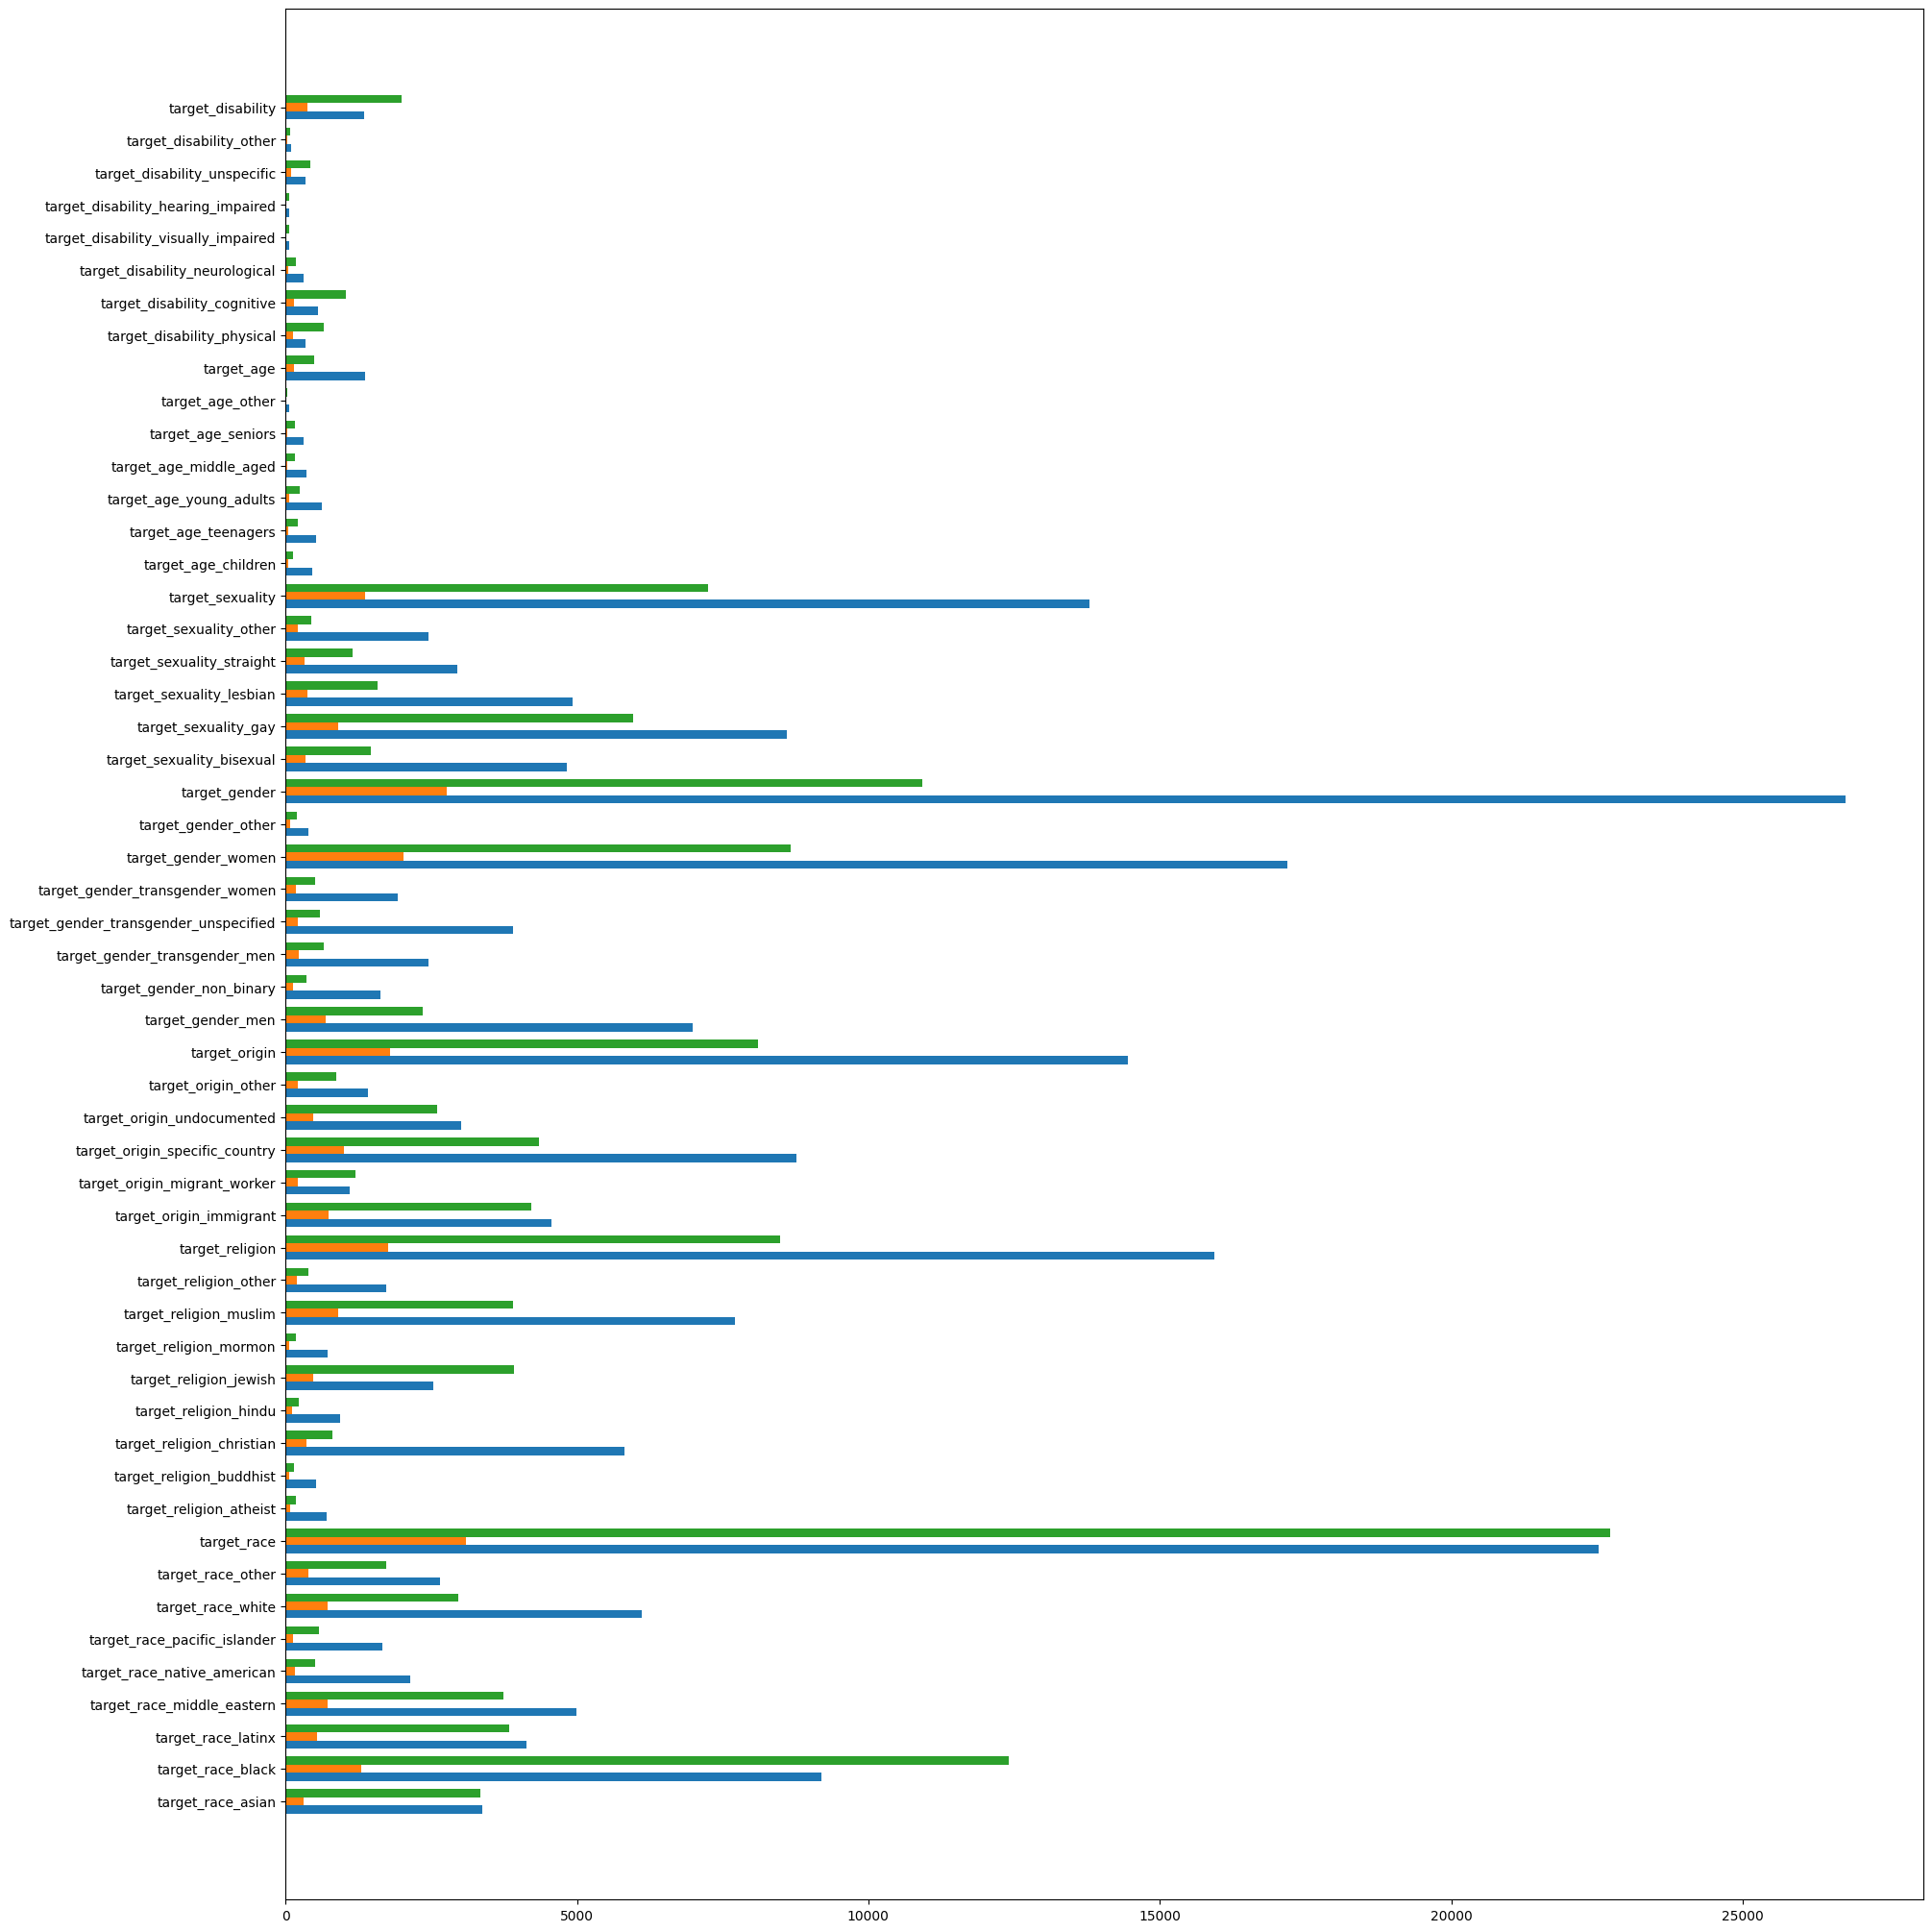

In [49]:
grouped = df[['hatespeech',*target_cols]].groupby('hatespeech').sum()

x = np.arange(len(grouped.columns))
fig, ax = plt.subplots(layout='constrained',figsize=(20,20))
width = 0.25
multiplier = 0
for hatespeech_val in grouped.index:
    offset = width * multiplier
    group = grouped.loc[hatespeech_val].values
    ax.barh(x+offset,group,width)
    # plt.xlabel('Counts')
    # plt.ylabel('Columns')
    multiplier +=1

ax.set_yticks(x + width, grouped.columns)
plt.show()

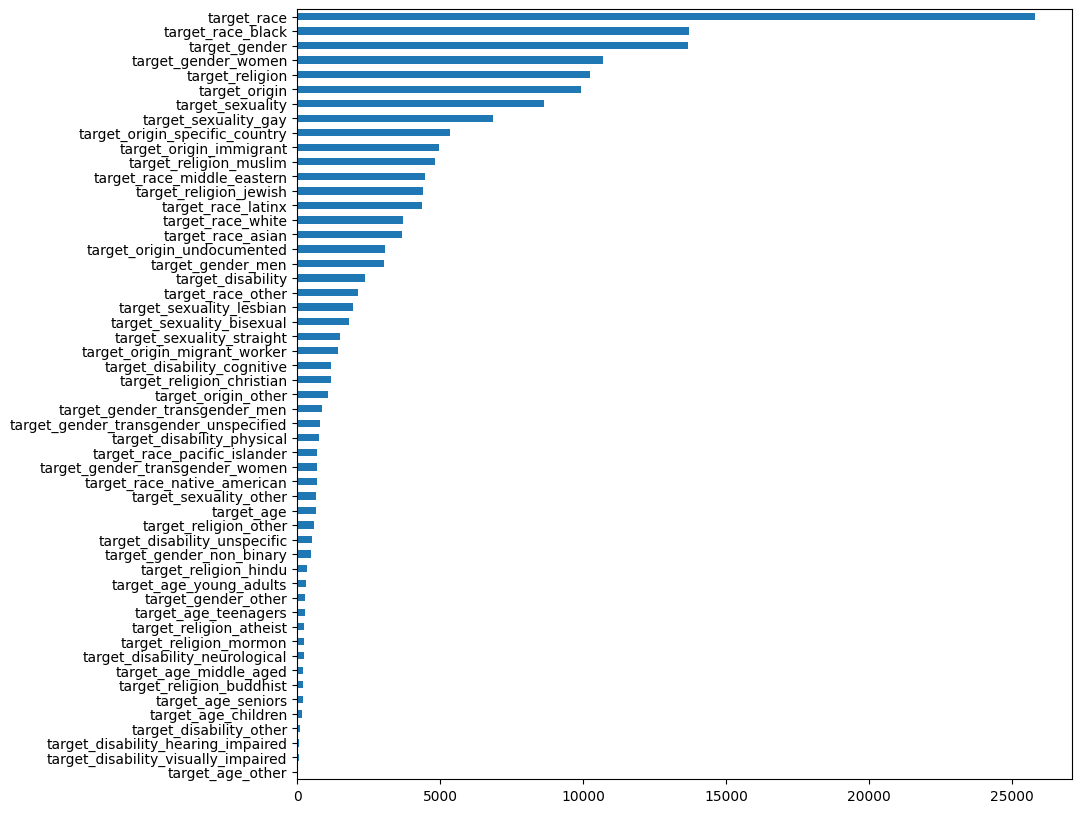

In [219]:
plt.figure(figsize=(10,10))
df[df['hatespeech']!=0][target_cols].sum().sort_values().plot(kind='barh')
plt.show()

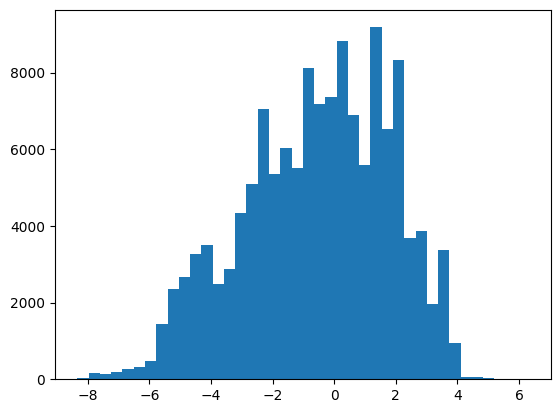

In [74]:
plt.hist(df['hate_speech_score'],bins=40)
plt.show()

In [75]:
df[other_cols].nunique()

std_err                 75
attack_defend            5
genocide                 5
infitms                413
respect                  5
platform                 4
status                   5
sentiment                5
text                 39565
comment_id           39565
insult                   5
violence                 5
dehumanize               5
hypothesis           39460
humiliate                5
hatespeech               3
outfitms               639
hate_speech_score     1255
dtype: int64

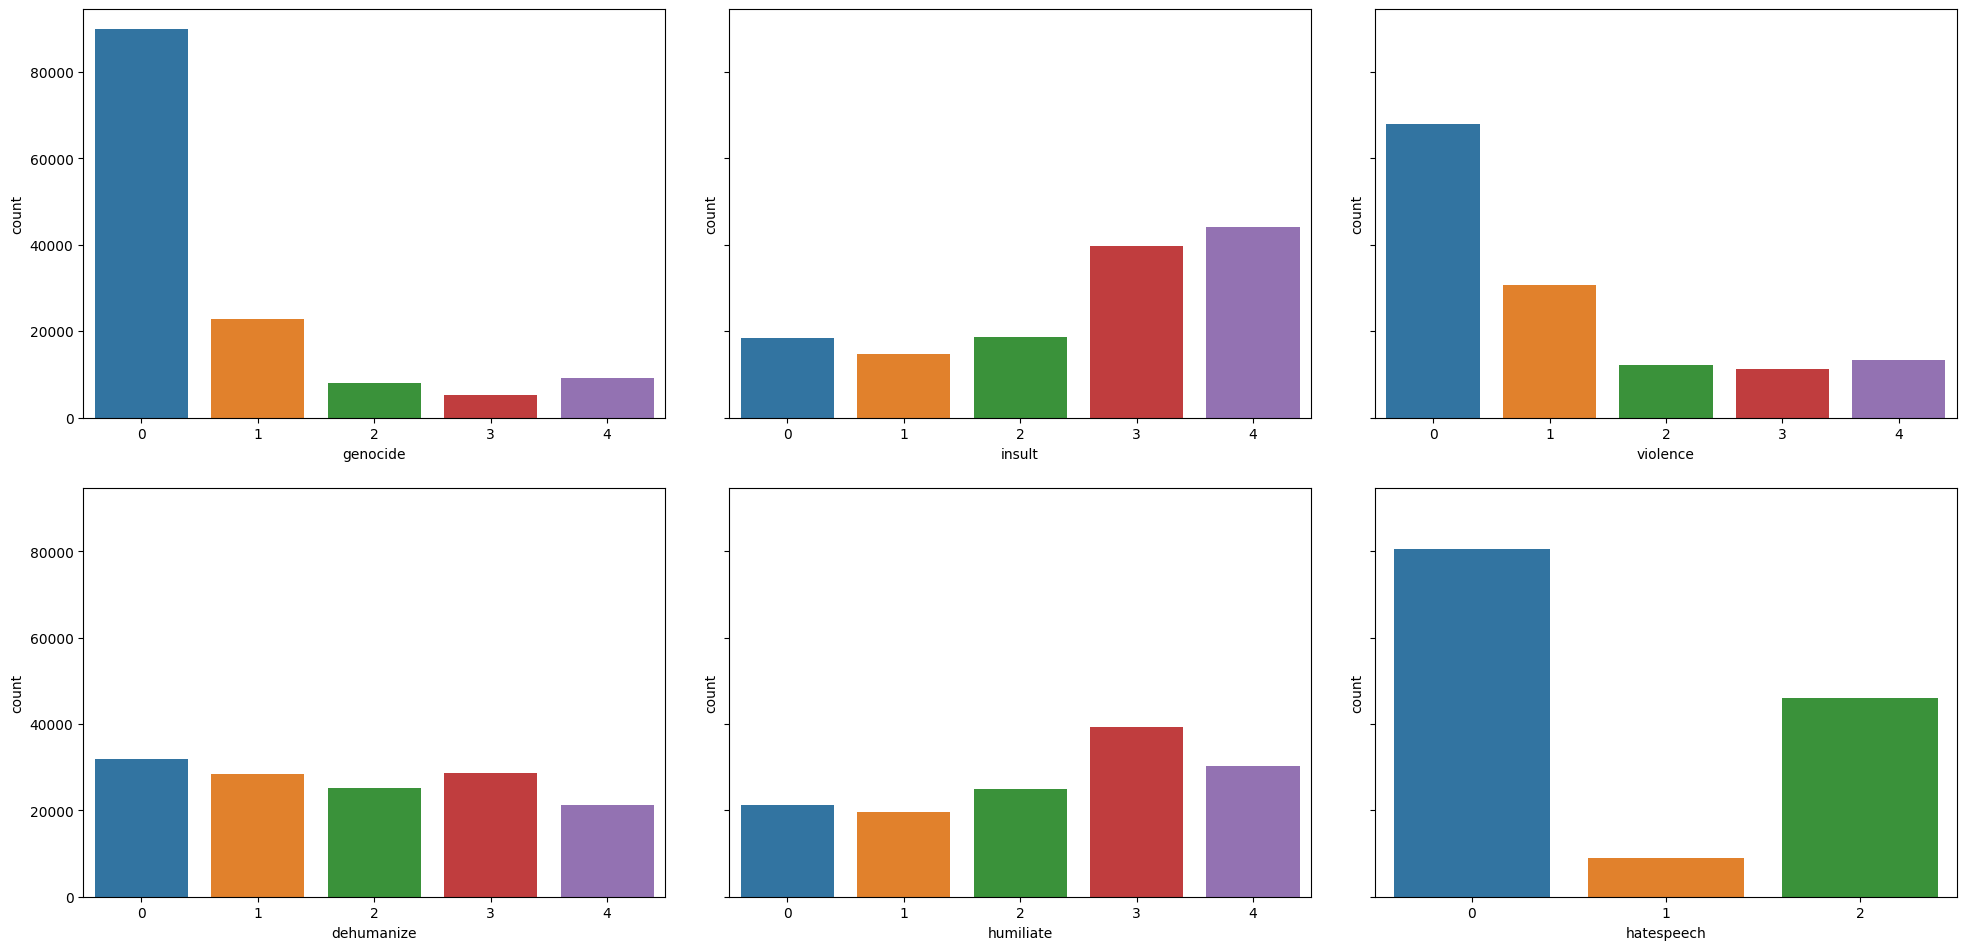

In [105]:
fig, axes = plt.subplots(2, 3,figsize=(20,10),sharey=True)
fig.tight_layout(pad=3)

for i, ax in zip(['genocide','insult','violence','dehumanize','humiliate','hatespeech'],axes.ravel()):
    sns.countplot(x=i,data=df,ax=ax)

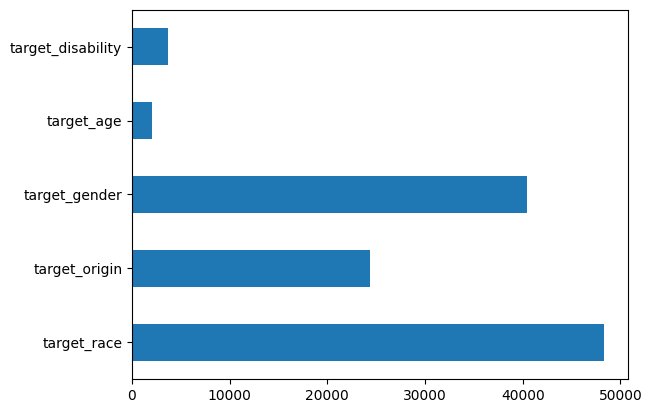

In [108]:
df[['target_race','target_origin','target_gender','target_age','target_disability']].sum().plot(kind='barh')
plt.show()

In [109]:
df[other_cols].select_dtypes(exclude=int)

,std_err,infitms,text,hypothesis,outfitms,hate_speech_score
0,0.34,0.81,Yes indeed. She sort of reminds me of the elde...,-1.130178,1.88,-3.90
1,1.00,0.96,The trans women reading this tweet right now i...,-1.146973,0.43,-6.52
2,0.31,0.90,Question: These 4 broads who criticize America...,-0.207369,0.74,0.36
3,0.29,0.81,It is about time for all illegals to go back t...,-0.055536,0.68,0.26
4,0.51,0.76,For starters bend over the one in pink and kic...,0.104225,0.63,1.54
...,...,...,...,...,...,...
135551,0.69,0.16,عاجل سماحة #السيد_عبدالملك_بدرالدين_الحوثي نص...,-0.036250,0.11,-4.88
135552,0.35,1.30,Millions of #Yemen-is participated in mass ral...,-0.974684,0.43,-4.40
135553,0.37,1.11,@AbeShinzo @realDonaldTrump @shinzoabe 独裁者は行きま...,-0.491960,1.29,-2.49
135554,0.35,1.30,Millions of #Yemen-is participated in mass ral...,-0.974684,0.43,-4.40


In [111]:
from wordcloud import WordCloud, STOPWORDS

In [136]:
def make_wordcloud(df):
    comment_words=""
    for val in df.text: 
        val = str(val).lower()
        comment_words += val+" "

    wordcloud = WordCloud(width = 800, height = 800,
                stopwords=STOPWORDS,
                background_color ='white',min_font_size = 10).generate(comment_words)
  
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

### Hatespeech Wordcloud

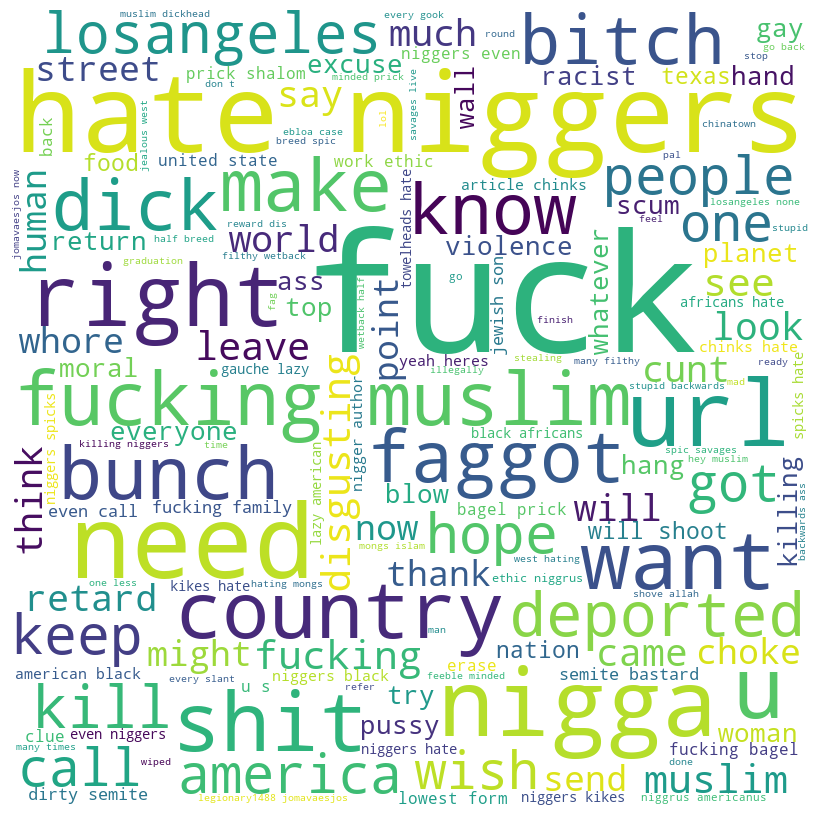

In [137]:
make_wordcloud(df[df['hatespeech']!=0])

### Genocide Wordcloud

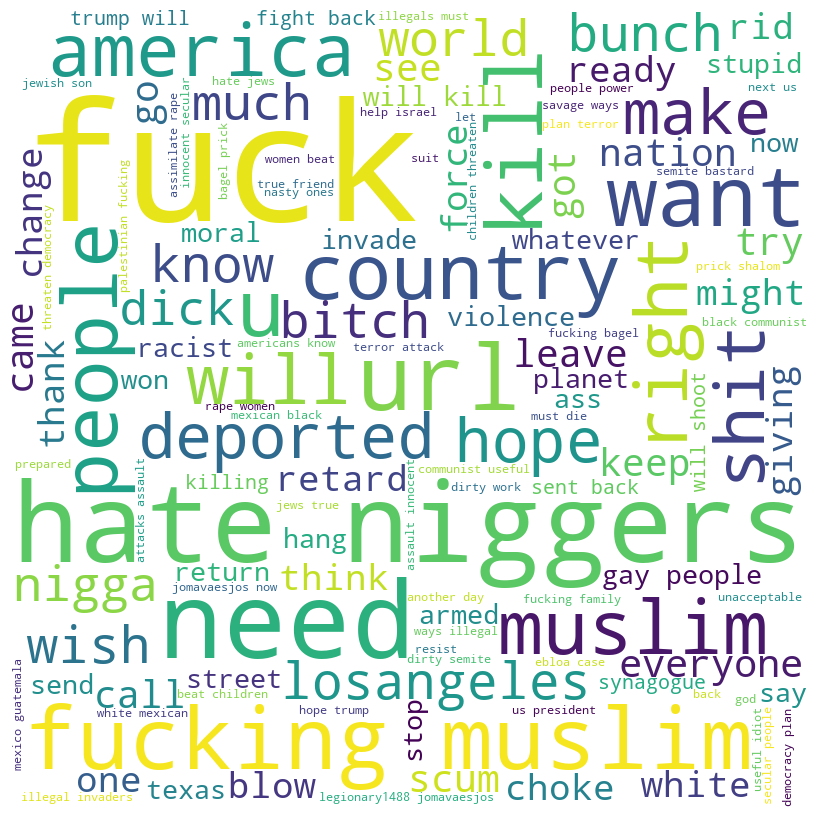

In [139]:
make_wordcloud(df[df['genocide']!=0])

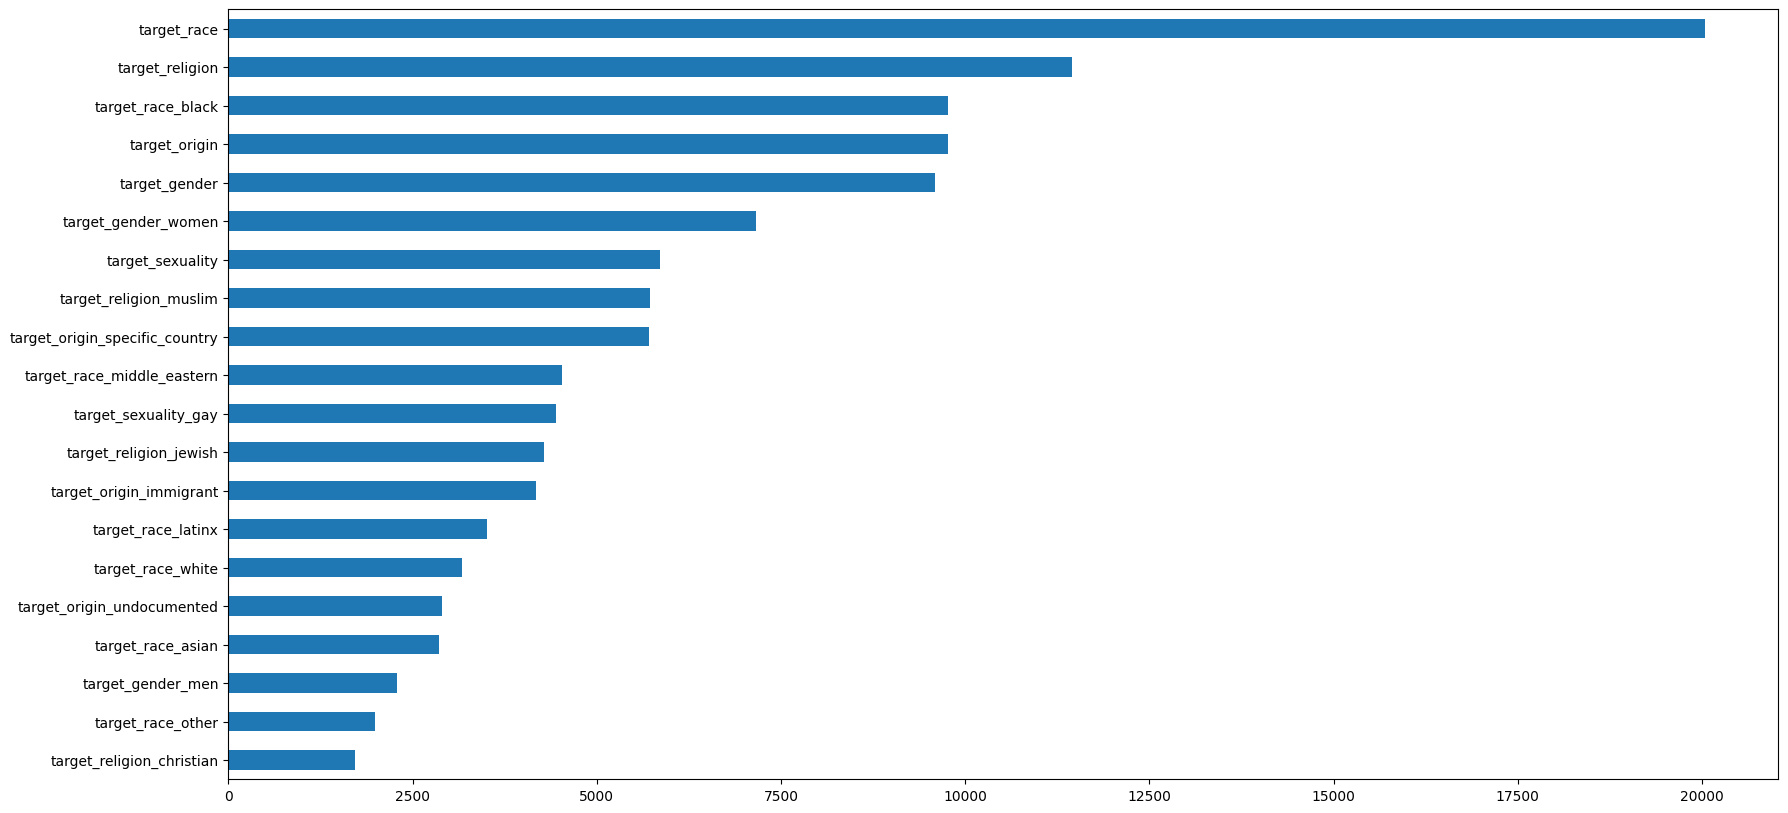

In [170]:
plt.figure(figsize=(20,10))
df[df['genocide']!=0][target_cols].sum().sort_values()[-20:].plot(kind='barh')
plt.show()

In [149]:
target_religion_cols = [col for col in df.columns if 'target_religion' in col]
target_race_cols = [col for col in df.columns if 'target_race' in col]
target_gender_cols = [col for col in df.columns if 'target_gender' in col]
target_sexuality_cols = [col for col in df.columns if 'target_sexuality' in col]
target_age_cols = [col for col in df.columns if 'target_age' in col]

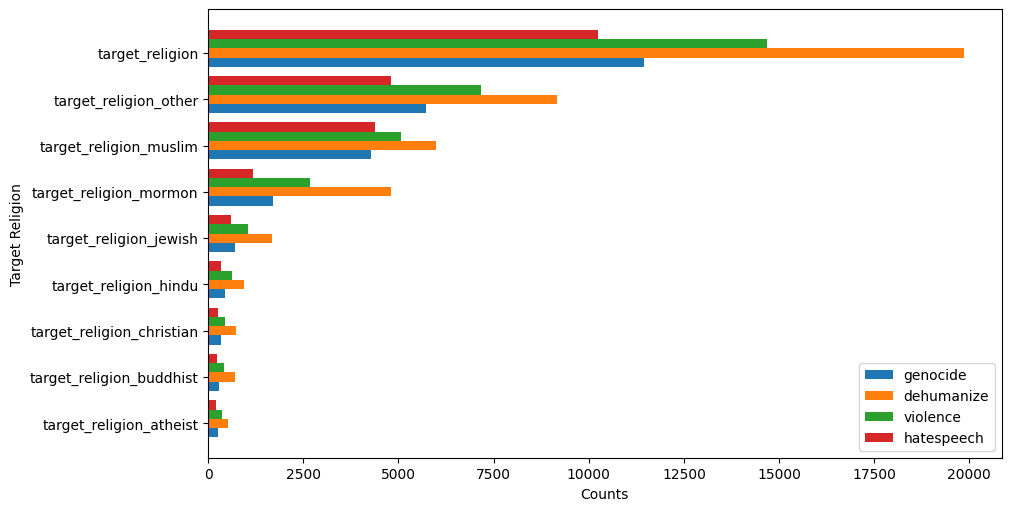

In [211]:
x = np.arange(len(target_religion_cols))
fig, ax = plt.subplots(layout='constrained',figsize=(10,5))
width = 0.2
multiplier = 0
for i in ['genocide','dehumanize','violence','hatespeech']:
    offset = width * multiplier
    group = df[df[i]!=0][target_religion_cols].sum().sort_values().values
    ax.barh(x+offset,group,width)
    plt.xlabel('Counts')
    plt.ylabel('Target Religion')
    multiplier +=1

ax.set_yticks(x + width, target_religion_cols)
ax.legend(['genocide','dehumanize','violence','hatespeech'])
plt.show()